In [22]:
from generator import Generator
from critic import Critic
from dog_dataset import DogData

In [50]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import optim

In [24]:
batchSize = 10

In [25]:
transform = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) ] )
dogdata = DogData(transform)
dogloader = DataLoader(dogdata, shuffle=True, batch_size=batchSize, num_workers=3)

In [39]:
def get_critic_scores(real_batch, batchSize, critic, generator):
    generator.batchSize = batchSize
    critic.batchSize = batchSize
    #generate fake images
    randoBatch = torch.rand([batchSize, 512, 1, 1])
    generated = generator(randoBatch)
    #compute scores of both real and fake using the critic
    real_scores = critic(real_batch[0])
    gen_scores = critic(generated)
    return ( torch.sum(real_scores) , torch.sum(gen_scores) )

In [44]:
def get_generator_score(batchSize, critic, generator):
    generator.batchSize = batchSize
    #generate fake images
    randoBatch = torch.rand([batchSize, 512, 1, 1])
    generated = generator(randoBatch)
    #compute scores of generated using critic
    gen_scores = critic(generated)
    return torch.sum(gen_scores)

In [62]:
critic = Critic()
generator = Generator()

In [63]:
num_epochs = 10
critic_epochs = 2
gen_epochs = 2

In [64]:
criticOptim = optim.SGD(critic.parameters(), lr=0.01, momentum=0.9)
genOptim = optim.Adam(generator.parameters(), lr=0.0001)

In [66]:
for epoch in range(num_epochs):
    print('Entering epoch yay: ' + str(epoch))
    realScore = 0.0 
    fakeScore = 0.0
    mainLoss = 0.0
    #critic training loop
    for batch_no, batch in enumerate(dogloader):
        print('Critic batch: ' + str(batch_no))
        scores = get_critic_scores(batch, batchSize, critic, generator)
        real_score = scores[0]
        gen_score = scores[1]
        #loss function
        loss = -( real_score - gen_score )
        #some tracking of numbers here
        realScore += real_score.item()
        fakeScore += gen_score.item()
        mainLoss += loss.item()
        #optimize
        criticOptim.zero_grad()
        loss.backward()
        criticOptim.step()
        
        if (batch_no % critic_epochs == critic_epochs-1):
            break
    print(realScore)
    print(fakeScore)
    print(mainLoss)

Entering epoch yay: 0
Critic batch: 0
Critic batch: 1
-34.80438423156738
-50.35833740234375
-15.553953170776367
Entering epoch yay: 1
Critic batch: 0
Critic batch: 1
-37.849477767944336
-53.908992767333984
-16.05951499938965
Entering epoch yay: 2
Critic batch: 0
Critic batch: 1
-50.317569732666016
-74.02398300170898
-23.70641326904297
Entering epoch yay: 3
Critic batch: 0
Critic batch: 1
-73.34841537475586
-95.770751953125
-22.42233657836914
Entering epoch yay: 4
Critic batch: 0
Critic batch: 1
-96.35911178588867
-132.41139221191406
-36.05228042602539
Entering epoch yay: 5
Critic batch: 0
Critic batch: 1
-123.40614318847656
-146.65933227539062
-23.253189086914062
Entering epoch yay: 6
Critic batch: 0
Critic batch: 1
-174.52521514892578
-225.50379943847656
-50.97858428955078
Entering epoch yay: 7
Critic batch: 0
Critic batch: 1
-202.09525299072266
-244.31690979003906
-42.221656799316406
Entering epoch yay: 8
Critic batch: 0
Critic batch: 1
-208.62784576416016
-312.5621337890625
-103.934

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


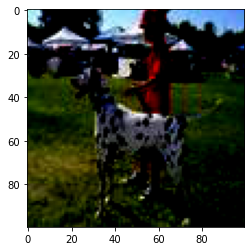

tensor([[-7.3547]], grad_fn=<AddmmBackward>)
tensor([[-1210.5780]], grad_fn=<AddmmBackward>)


In [75]:
import matplotlib.pyplot as plt
plt.imshow(dogdata[0][0].permute(1,2,0))
plt.show()

critic.batchSize = 1
critic.eval()
print(critic(dogdata[0][0].unsqueeze(0)))
rando = torch.rand([1, 512, 1, 1])
print(critic(generator(rando)))